In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential, layers

In [2]:
train_ds, test_ds = cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
def show_images(images):
    n = len(images)
    for i , image in enumerate(images):
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.axis("off")

    plt.show()

In [4]:
IMG_SIZE = 64
resize_and_rescale = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1/255.)
])

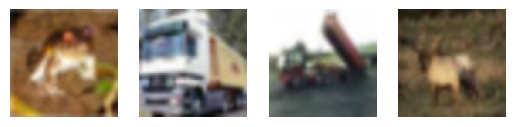

In [5]:
resized_images = train_ds.take(4).map(lambda x, y: resize_and_rescale(x))

show_images(resized_images)


In [6]:
data_augumentation  = Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(factor=0.2),
    layers.RandomContrast(factor=(0.2, 0.9))
])

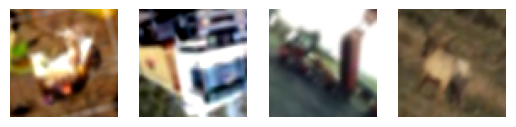

In [7]:
aug_images = resized_images.map(data_augumentation)
show_images(aug_images)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
def prepare(ds):
    return ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE) \
        .map(lambda x, y:( data_augumentation(x), y), num_parallel_calls=AUTOTUNE) \
        .prefetch(buffer_size =AUTOTUNE)



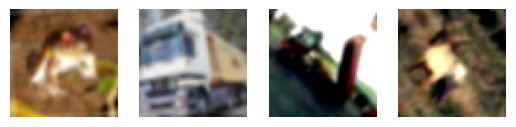

In [10]:
prepared_ds = prepare(train_ds).take(4)
show_images(prepared_ds.map(lambda x, y: x))


In [11]:
image, label = next(iter(train_ds))

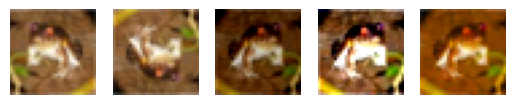

In [12]:
show_images([
    tf.image.flip_left_right(image),
    tf.image.flip_up_down(image),
    tf.image.adjust_brightness(image, -0.2),
    tf.image.adjust_contrast(image, 2),
    tf.image.adjust_saturation(image, 2)
])

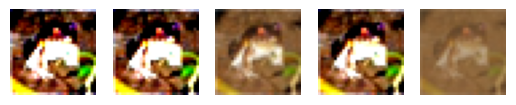

In [13]:
show_images([
    tf.image.stateless_random_contrast(image, lower=0.1, upper=5, seed=(i, 0))
    for i in range(1, 6)
])

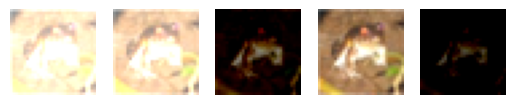

In [14]:
show_images([
    tf.image.stateless_random_brightness(image, max_delta=0.8, seed=(i, 0))
    for i in range(1, 6)
])

In [27]:
IMG_SIZE = 64

def resize_and_rescale(img):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))  # directly resize to IMG_SIZE
    img = img / 255.0
    return img

def augment(img_label, seed):
    image, label = img_label
    image = resize_and_rescale(image)
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

rng = tf.random.Generator.from_seed(1, alg='philox')

def aug_wrap(img, label):
    seed = rng.make_seeds(2)[0]
    img, label = augment((img, label), seed)
    return img, label

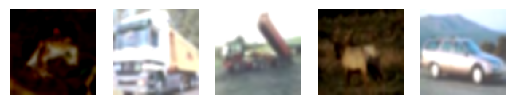

In [28]:
aug_ds = train_ds.take(5).map(aug_wrap)
show_images(aug_ds.map(lambda x, y: x))